# Processing statistics files

In this example we show how one can use pynektools to process statistics

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

# Hide the log for the notebook. Not recommended when running in clusters as it is better you see what happens
import os
os.environ["PYNEKTOOLS_HIDE_LOG"] = 'true'


## Index the files

The first step we will do is to index the files that we will use for this example. By indexing we mean that we will gather a json file that will contain all the information of the files we want to process.
We do this to ease the process of averaging, since we can easily inspect what are the attributes of the files.

In our case we will index statistics files produced from neko, but one could also index other type of files. This only works for nek5000 type of files.

you can check the documentation for this. We note that at this stage, it is important to include the time interval in the indexing.

In [2]:
from pynektools.postprocessing.file_indexing import index_files_from_folder

index_files_from_folder(comm, folder_path="../data/sem_data/statistics/cylinder_rbc_nelv_600/", run_start_time=200, stat_start_time=200, output_folder="./", file_type=["mean_field.fld", "stats.fld"], include_file_contents=True, include_time_interval=True)

Now we have written a file index with the two types of files in the input folder. If you inspect the file, you will see that there is a lot of information regarding the files. We will use this info to average them in time.

## Average in time

For this, we simply give as inputs the files that we just wrote.

In this case, we are choosing the output batch lenght to be a very large number, such that we do not get average batches, but instead we average all the files. The mesh index indicates which is the json index of the files that contain the mesh.

You can check more about the arguments of the functions if you inspect them.

In [3]:
from pynektools.postprocessing.statistics.time_averaging import average_field_files

# Average the mean fields
average_field_files(comm, field_index_name="mean_field_index.json", output_folder="./", output_name="low_order_stats", output_batch_t_len=50000, mesh_index="0", dtype=np.single, rel_tol=0.05, output_word_size=4, write_mesh=True)

# Average the stats fields
average_field_files(comm, field_index_name="stats_index.json", output_folder="./", output_name="high_order_stats", output_batch_t_len=50000, mesh_index="0", dtype=np.single, rel_tol=0.05, output_word_size=4, write_mesh=True)

done! now you have obtained some fld files that contain 3D time averaged data in an spectral mesh. With this, you can easily visualize it in paraview or visit.

## Interpolate

The data for this example corresponds to a simulation on a cylinder. Because of this we would like to interpolate form the spectral element mesh into a cylindrical mesh.

You can see example 4.5 to see how this mesh is created. In here, we use the results from that script to interpolate the data.

### 1. index the new outputs

We will initially index the new outputs just to have a convenient way to know the path of our data.

In [4]:
index_files_from_folder(comm, folder_path="./", output_folder="./", file_type=["low_order_stats.fld", "high_order_stats.fld"], include_file_contents=False, include_time_interval=False)

### 2. Use wrapper function to interpolate

now that we have indexed, we can use this to interpolate. We will use a wrapper function to interpolate the contents of the files. You can check example 4.6 for more details.

For this, we first need to prepare a "settings" file

In [5]:
from pynektools.interpolation.wrappers import interpolate_fields_from_disk

# Set the inputs for the first set of files
query_points_fname = "../4-interpolation/points.hdf5"
sem_mesh_fname = "./low_order_stats0.f00000"
interpolated_fields_output_fname = "./low_order_stats_interpolated.hdf5"
field_interpolation_dictionary = {}
field_interpolation_dictionary['input_type'] = "file_index"
field_interpolation_dictionary['file_index'] = f"low_order_stats_index.json"
field_interpolation_dictionary['fields_to_interpolate'] = ["all"]
interpolate_fields_from_disk(comm, query_points_fname, sem_mesh_fname, field_interpolation_dictionary, interpolated_fields_output_fname=interpolated_fields_output_fname)

# Set the inputs for the second set of files
query_points_fname = "../4-interpolation/points.hdf5"
sem_mesh_fname = "./high_order_stats0.f00000"
interpolated_fields_output_fname = "./high_order_stats_interpolated.hdf5"
field_interpolation_dictionary = {}
field_interpolation_dictionary['input_type'] = "file_index"
field_interpolation_dictionary['file_index'] = f"high_order_stats_index.json"
field_interpolation_dictionary['fields_to_interpolate'] = ["all"]
interpolate_fields_from_disk(comm, query_points_fname, sem_mesh_fname, field_interpolation_dictionary, interpolated_fields_output_fname=interpolated_fields_output_fname)

## Visualize the data in the cylindrical mesh

 We can now load the data and check it out.

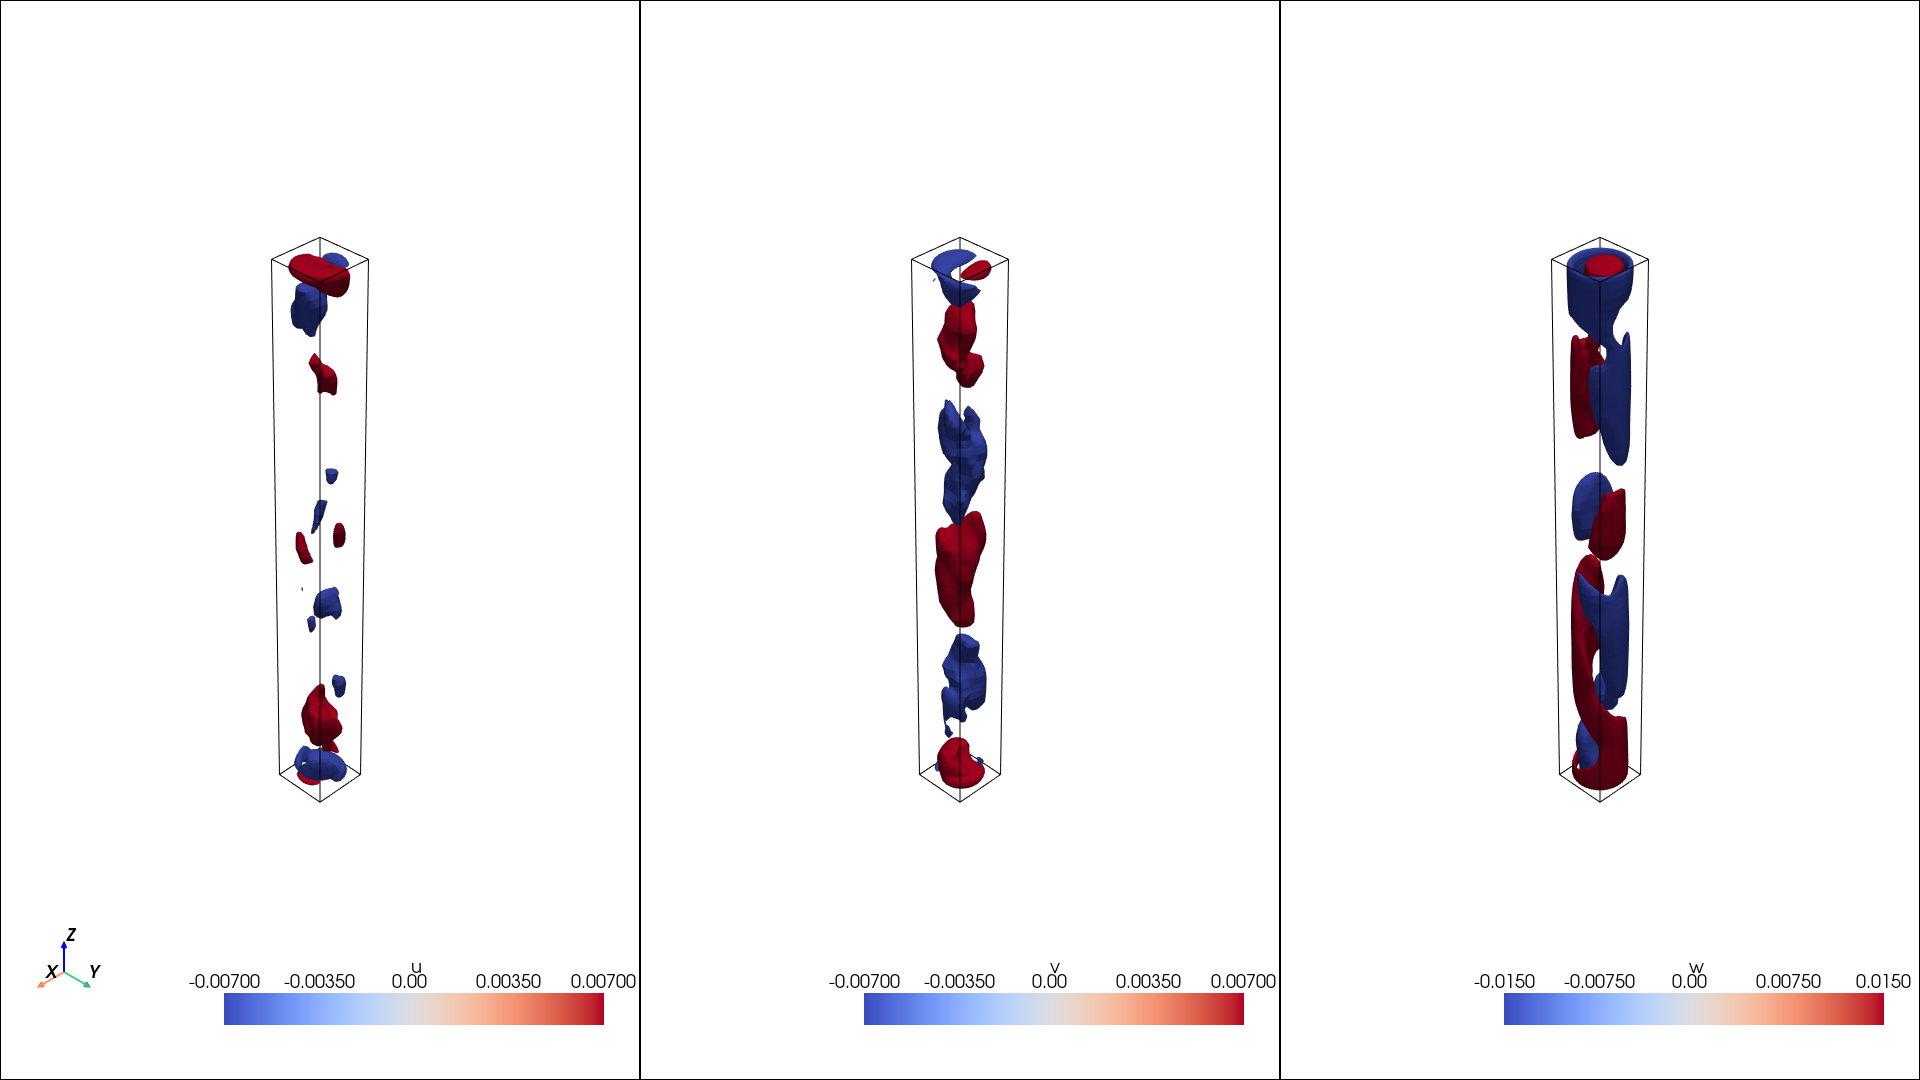

In [28]:
import h5py
import pyvista as pv
from IPython.display import Image, display


# Load the mesh
with h5py.File(query_points_fname, 'r') as f:
    x = f["x"][:]
    y = f["y"][:]
    z = f["z"][:]

# Load the interpolated data
with h5py.File("./low_order_stats_interpolated00001.hdf5", 'r') as f:
    u = f["u"][:]
    v = f["v"][:]
    w = f["w"][:]

# Create a structured mesh
mesh_1 = pv.StructuredGrid(x, y, z)
mesh_1.point_data["u"] = u.ravel(order='F')
mesh_1.point_data["v"] = v.ravel(order='F')
mesh_1.point_data["w"] = w.ravel(order='F')

# Plot
pl = pv.Plotter(shape=(1, 3), window_size=[1920,1080]) # Size in pixels
pl.add_axes() 
# plot first row
pl.subplot(0, 0)
isos = mesh_1.contour(scalars = "u", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 1)
isos = mesh_1.contour(scalars = "v", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 2)
isos = mesh_1.contour(scalars = "w", isosurfaces = [-0.015, 0.015])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

#pl.show()

# Capture the plot as an image and show it
image_path = "static_plot.png"
pl.screenshot(image_path)
pl.close()
display(Image(filename=image_path))